## 1D bar, finite difference method

In [123]:
import numpy as np
import sympy as sp
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt


Assume the following numerical values and define a spatial mesh

In [124]:
L=1000 #length of body mm
Emod=200.e3 #N/mm^2
Kx=100. #=N/mm^3 

nel=1000; #number of elements
ndofs=round(nel+1) #number of dof (number of node displacements)
Ex=np.linspace(0,L,ndofs)
dx=Ex[1]-Ex[0]


Define time history

In [125]:
tend=1000
ntime=1000
# time history    
tt = np.linspace(0, tend, ntime)
dt=tt[1]-tt[0] #assume constant time step

Define a body load function based on Hertzian load (1d)

In [126]:


def hertz_distribution(x, a, Kx0, velocity, time):
    """
    Computes the Hertz Kx distribution 
    
    Parameters:
    - x: grid points (x coordinates).
    - a: Load radius (half-width of the load length).
    - Kx0: Maximum Kx at the center.
    
    Returns:
    - Kx_values: Kx values at each x  point.
    """
    x0=velocity*time
    # Compute the radius from the center
    r = np.sqrt((x-x0)**2) 
    
    # Pressure distribution (Hertz formula)
    Kx_distribution = np.where(r <= a, Kx0 * np.sqrt(np.abs( 1.0001 - (r / a)**2)) , 0)
    
    return Kx_distribution

def tent_distribution(x, a, Kx0, velocity, time):
    """
    Computes the tent-like Kx distribution 
    
    Parameters:
    - x: grid points (x coordinates).
    - a: Load radius (half-width of the load length).
    - Kx0: Maximum Kx at the center.
    
    Returns:
    - Kx_values: Kx values at each x  point.
    """
    x0=velocity*time
    # Compute the radius from the center
    r = np.sqrt((x-x0)**2) 
    
    # Pressure distribution (Hertz formula)
    Kx_distribution = np.where(r <= a, Kx0 * (1 - r / a), 0)
    
    return Kx_distribution



Data for body load, and graphical illustration

Text(0.5, 1.0, 'body load distribution at half-time')

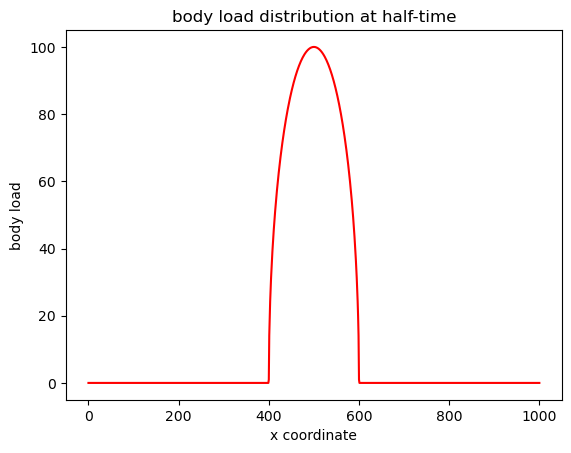

In [127]:
###
body_width=L/10 #assume portion of the total length
velocity=L/tend #assume that the load travels the full length

#plot a figure how the temperature load looks like at half-time
body_plot=hertz_distribution(Ex, body_width, Kx, velocity, tend/2)  
plt.plot(Ex,body_plot, 'r', label='intial temperature field')
plt.xlabel('x coordinate')
plt.ylabel('body load')
plt.title('body load distribution at half-time')

### Finite difference method to solve the bar equation

Bar equation
$$
\frac{d^2u}{dx^2}+\frac{K_x}{E}=0
$$
with boundary conditions $u(0)=0$ and $u'(L)=0$ (since no external normal force).

Finite difference method
$$
\frac{du(x)}{dx}\approx \frac{u(x)-u(x-\Delta x)}{\Delta x}
$$
$$
\frac{d^2u(x)}{dx^2}\approx \frac{u(x+\Delta x)-2\, u(x)+u(x-\Delta x)}{\Delta x^2}
$$

Boundary conditions and finite difference approximations $\Rightarrow$
$$
u_1=0
$$
$$
\frac{1}{\Delta x^2}
\begin{bmatrix}
-2 & 1 &0 & \ldots & 0 &0 \\
1 & -2 &1 & \ldots & 0 &0 \\
\vdots &   &  &  & & \\
0 & 0 &\ldots & 1 & -2 &1 \\
0 & 0 &\ldots & 0 & 1 &-1 \\
\end{bmatrix}
\begin{bmatrix}
u_2 \\ u_3 \\ \ldots \\ u_{ndof-1} \\ u_{ndof}
\end{bmatrix}
+\begin{bmatrix}
K_x(x_2)/E \\
\vdots
\\
K_x(x_{n_{dof}-1})/E \\
0
\end{bmatrix}=\begin{bmatrix}
\vdots \\
0 \\
\vdots
\end{bmatrix}
$$
Note that last equation $u_{ndof}-u_{ndof-1}$ approximates $u'(L)=0$. 


Now we build the matrix $A$:

In [128]:
A=np.zeros((ndofs-1,ndofs-1))
# Set the main diagonal to -2
np.fill_diagonal(A, -2)
# Set the upper diagonal to 1
np.fill_diagonal(A[:, 1:], 1)
# Set the lower diagonal to 1
np.fill_diagonal(A[1:, :], 1)
# Modify the last diagonal entry for the boundary condition
A[-1, -1] = -1  # since du/dx=0 at x=L

A=A/(dx**2)
#slow version ..
# for i in range(ndofs-2):
#     A[i,i]=-2
#     if i<(ndofs-3):
#         A[i,i+1]=1
#     if i>0:
#         A[i,i-1]=1
            
# A[-1,-1]=-1 #since du/dx=0 at x=L
print('A=', A)

A= [[-2.  1.  0. ...  0.  0.  0.]
 [ 1. -2.  1. ...  0.  0.  0.]
 [ 0.  1. -2. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ... -2.  1.  0.]
 [ 0.  0.  0. ...  1. -2.  1.]
 [ 0.  0.  0. ...  0.  1. -1.]]


In [129]:

from scipy.sparse import csr_matrix
from scipy.sparse.linalg import spsolve

#use sparse matrix to speed up
As = csr_matrix(A, shape=(ndofs-1, ndofs-1))



Now we solve for the unknowns in each timestep

In [130]:

Kx_values=np.zeros((ndofs-1,)) #initial Kx values
a_hist=np.zeros((ndofs,ntime))
for i in range(ntime):
    for j in range(ndofs-2): #note that last node has no load
        Kx_values[j]=hertz_distribution(Ex[j+1], body_width, Kx, velocity, tt[i]) 
    #here is the solution of the unknowns in each timestep
    a=spsolve(As,-Kx_values/Emod)
    a_hist[1:,i]=a #save in history matrix, note that a[0] is always zero due to BC
    

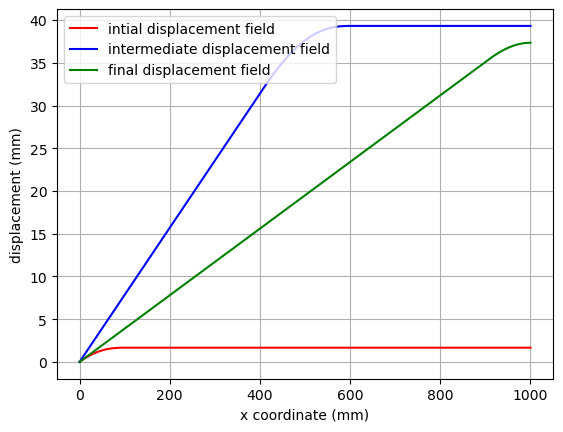

In [131]:

#
plt.plot(Ex,a_hist[:,0], 'r', label='intial displacement field')
plt.plot(Ex,a_hist[:,round(ntime/2)], 'b', label='intermediate displacement field')
plt.plot(Ex,a_hist[:,-1], 'g', label='final displacement field')
plt.xlabel('x coordinate (mm)')  # Label for the x-axis
plt.ylabel('displacement (mm)')  # Label for the y-axis
plt.legend()
plt.grid()
plt.show()

Singular values: 
 [3.05816975e+04 3.30964176e+03 1.13219944e+03 5.34800791e+02
 2.91241771e+02 1.70144301e+02 1.02587039e+02 6.21650805e+01
 3.69626711e+01 2.09379495e+01]


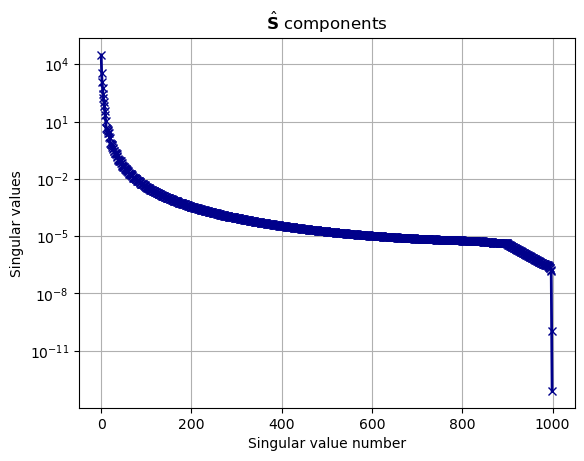

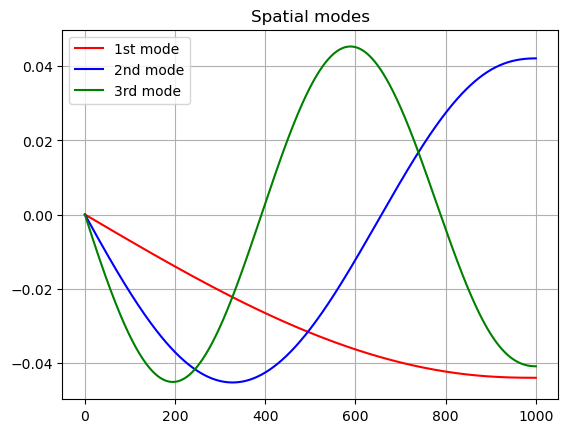

In [132]:
# Economy SVD of a_hist
X=a_hist

Uec, Sec, VTec = np.linalg.svd(X, full_matrices=False)

print('Singular values: \n', Sec[0:10])

## Plot the singular values of Shat:
fig, ax = plt.subplots()
ax.semilogy(Sec, linewidth=2.0, label='t=0', marker='x', color='darkblue')
ax.set_title(r'$\hat{\mathbf{S}}$ components')
plt.xlabel('Singular value number')
plt.ylabel('Singular values')
plt.grid()
plt.show()

plt.title('Spatial modes')
plt.plot(Ex,Uec[:,0], 'r', label='1st mode')
plt.plot(Ex,Uec[:,1], 'b', label='2nd mode')
plt.plot(Ex,Uec[:,2], 'g', label='3rd mode')
plt.grid()
plt.legend()
plt.show()

Save a reduced number of singular vectors $U$ in $\Phi$

In [133]:
nr=20
Phi=np.zeros((ndofs,nr))
for i in range(nr):
    Phi[:,i]=Uec[:,i]



Approximate displacement field as

$$
u(x) \approx \sum_{k=1}^{n_r}  \Phi_k(x) \, b_k =\mathbf{\Phi} \, \mathbf{b}
$$

and its 2nd derivative
$$
u''(x) \approx \sum_{k=1}^{n_r} \Phi''_k(x) \, b_k=\mathbf{\Phi}'' \, \mathbf{b}
$$
where numerical differentiation is used to compute $\mathbf{\Phi}'' $ either using "numpy.gradient" or your own code 


In [134]:
dPhi_dx=np.zeros((ndofs,nr))
for i in range(nr):
    dPhi_dx[:,i] = np.gradient(Phi[:,i], Ex)
d2Phi_dx2=np.zeros((ndofs,nr))
for i in range(nr):
    d2Phi_dx2[:,i] = np.gradient(dPhi_dx[:,i], Ex)

#my own code
#d2Phi_dx2=np.zeros((ndofs,nr))
#for i in range(1,ndofs-1):
#    d2Phi_dx2[i,:]=(Phi[i+1,:]-2.*Phi[i,:]+Phi[i-1,:])/dx**2
    

Now solve for the unknowns $b_k$ from the differential equation:

In [135]:
b_hist=np.zeros((nr,ntime))
from scipy import linalg
#use sparse matrix to speed up
As = csr_matrix(A, shape=(ndofs-1, ndofs-1))
Kx_values=np.zeros((ndofs,)) #initial Kx values


for i in range(ntime):
    for j in range(ndofs-1):
        Kx_values[j]=hertz_distribution(Ex[j], body_width, Kx, velocity, tt[i]) 
    #Kx_values=hertz_distribution(Ex, body_width, Kx, velocity, tt[i])  #hertz_distribution(Ex[1:-1], body_width, Kx, velocity, tt[i]) 
    #print(Kx_values.shape) 
    b=np.linalg.pinv(d2Phi_dx2) @ (-Kx_values/Emod)  #nthe reason for using pinv is that we have more equations (one for each node position) than unknowns 
    b_hist[:,i]=b #save in history matrix


Now adopt the displacements can be computed 

In [136]:
a_hist_red=np.zeros((ndofs,ntime))
for i in range(ntime):
    a_hist_red[:,i]=Phi @ b_hist[:,i]

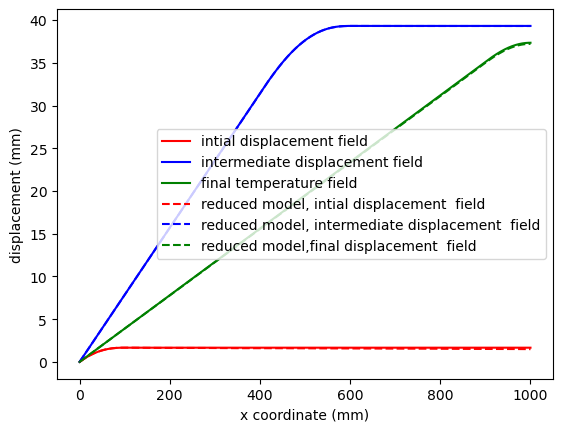

In [137]:

plt.plot(Ex,a_hist[:,0], 'r', label='intial displacement field')
plt.plot(Ex,a_hist[:,round(ntime/2)], 'b', label='intermediate displacement field')
plt.plot(Ex,a_hist[:,-1], 'g', label='final temperature field')


plt.plot(Ex,a_hist_red[:,0], 'r--', label='reduced model, intial displacement  field')
plt.plot(Ex,a_hist_red[:,round(ntime/2)], 'b--', label='reduced model, intermediate displacement  field')
plt.plot(Ex,a_hist_red[:,-1], 'g--', label='reduced model,final displacement  field')
plt.xlabel('x coordinate (mm)')  # Label for the x-axis
plt.ylabel('displacement (mm)')  # Label for the y-axis
plt.legend()

